# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

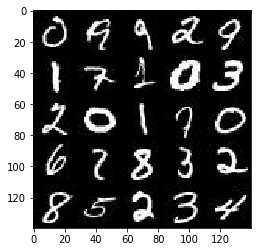

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

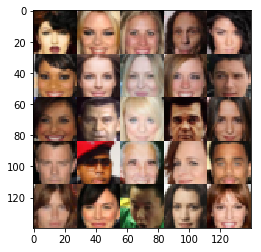

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real    = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name = 'input_real')
    input_z       = tf.placeholder(tf.float32, (None, z_dim), name = 'input_z')
    learning_rate = tf.placeholder(tf.float32, name = 'learning_rate')
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.1, kernel_size=4, keep_prob=0.5):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse = reuse):
        initializer = tf.contrib.layers.xavier_initializer_conv2d()
        
        # 14 x 14 x 64
        x1 = tf.layers.dropout(images, rate = keep_prob)
        x1 = tf.layers.conv2d(x1, 64, kernel_size, strides = 2, padding = 'same', kernel_initializer=initializer)
        x1 = tf.maximum(alpha * x1, x1)

        # 7 x 7 x 128
        x2 = tf.layers.conv2d(x1, 128, kernel_size, strides = 2, padding = 'same', kernel_initializer=initializer)
        x2 = tf.layers.batch_normalization(x2, training = True)
        x2 = tf.maximum(alpha * x2, x2)
        
        # 4 x 4 x 256
        x3 = tf.layers.conv2d(x2, 256, kernel_size, strides = 2, padding = 'same', kernel_initializer=initializer)
        x3 = tf.layers.batch_normalization(x3, training = True)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.layers.dropout(x3, rate = keep_prob)

        # logits(1)
        flat = tf.reshape(x3, (-1, 4 * 4 * 256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.1, kernel_size=4, keep_prob=0.5):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    reuse = True if not is_train else False
    with tf.variable_scope('generator', reuse = reuse):
        # 4 x 4 x 512
        x1 = tf.layers.dense(z, 4 * 4 * 512)
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training = is_train)
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.layers.dropout(x1, rate = keep_prob)
        
        # 7 x 7 x 256
        x2 = tf.layers.conv2d_transpose(x1, 256, kernel_size, strides = 1, padding = 'valid')
        x2 = tf.layers.batch_normalization(x2, training = is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        # 14 x 14 x 128
        x3 = tf.layers.conv2d_transpose(x2, 128, kernel_size, strides = 2, padding = 'same')
        x3 = tf.layers.batch_normalization(x3, training = is_train)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.layers.dropout(x3, rate = keep_prob)
        
        # 28 x 28 x out_channel_dim
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, kernel_size, strides = 2, padding = 'same')
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, smooth=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train = True)
    d_model_real, d_logits_real = discriminator(input_real, reuse = False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse = True)
    
    d_loss_real = tf.reduce_mean(
                        tf.nn.sigmoid_cross_entropy_with_logits(
                            logits = d_logits_real,
                            labels = tf.ones_like(d_logits_real) * (1 - smooth)
                        )
                    )
    
    d_loss_fake = tf.reduce_mean(
                        tf.nn.sigmoid_cross_entropy_with_logits(
                            logits = d_logits_fake,
                            labels = tf.zeros_like(d_logits_fake)
                        )
                    )
    
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(
                    tf.nn.sigmoid_cross_entropy_with_logits(
                        logits = d_logits_fake,
                        labels = tf.ones_like(d_logits_fake)
                    )
                )
    
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(g_loss, var_list = g_vars)
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(d_loss, var_list = d_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    # Check data range
    #data = list(get_batches(batch_size))
    # min_val = np.min(data)
    # max_val = np.max(data)
    min_val = -0.5 
    max_val = 0.5  
    print("Change value range of dataset from [{}, {}] to [-1, 1]".format(min_val, max_val))
    
    steps = 0
    one_epoch_steps = len(list(get_batches(batch_size)))
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # Scale from [min_val, max_val] to [-1, 1] for tanh
                batch_images = np.array(batch_images)
                batch_images = 2 * (batch_images - min_val) / (max_val - min_val) - 1
                batch_images = batch_images.tolist()
                
                # Input of Generator
                batch_z = np.random.uniform(-1, 1, size = (batch_size, z_dim))
                
                # Run optimizer
                _ = sess.run(d_opt, feed_dict = {input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict = {input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                steps_in_epoch = one_epoch_steps if steps % one_epoch_steps == 0 else steps % one_epoch_steps
                if steps_in_epoch == one_epoch_steps or steps_in_epoch % 10 == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z, lr: learning_rate})
                    train_loss_g = g_loss.eval({input_real: batch_images, input_z: batch_z, lr: learning_rate})

                    print("Epoch {}/{}\t".format(epoch_i + 1, epoch_count),
                          "Batch {}/{}\t".format(steps_in_epoch, one_epoch_steps),
                          "Discriminator Loss: {:.4f}\t".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps_in_epoch == one_epoch_steps or steps_in_epoch % 200 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Change value range of dataset from [-0.5, 0.5] to [-1, 1]
Epoch 1/2	 Batch 10/937	 Discriminator Loss: 0.8140	 Generator Loss: 16.2394
Epoch 1/2	 Batch 20/937	 Discriminator Loss: 0.4295	 Generator Loss: 4.4553
Epoch 1/2	 Batch 30/937	 Discriminator Loss: 5.3036	 Generator Loss: 0.0098
Epoch 1/2	 Batch 40/937	 Discriminator Loss: 0.5292	 Generator Loss: 5.1640
Epoch 1/2	 Batch 50/937	 Discriminator Loss: 0.6146	 Generator Loss: 2.7850
Epoch 1/2	 Batch 60/937	 Discriminator Loss: 1.3420	 Generator Loss: 0.5973
Epoch 1/2	 Batch 70/937	 Discriminator Loss: 0.7431	 Generator Loss: 1.8907
Epoch 1/2	 Batch 80/937	 Discriminator Loss: 0.6437	 Generator Loss: 4.1936
Epoch 1/2	 Batch 90/937	 Discriminator Loss: 0.4783	 Generator Loss: 3.6486
Epoch 1/2	 Batch 100/937	 Discriminator Loss: 0.5708	 Generator Loss: 2.7766
Epoch 1/2	 Batch 110/937	 Discriminator Loss: 0.6807	 Generator Loss: 4.5891
Epoch 1/2	 Batch 120/937	 Discriminator Loss: 0.7886	 Generator Loss: 2.1698
Epoch 1/2	 Batch 130/937	 

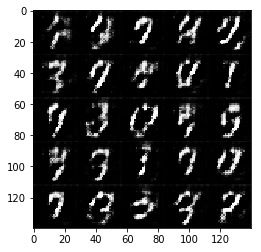

Epoch 1/2	 Batch 210/937	 Discriminator Loss: 1.9278	 Generator Loss: 0.3359
Epoch 1/2	 Batch 220/937	 Discriminator Loss: 0.8082	 Generator Loss: 1.7443
Epoch 1/2	 Batch 230/937	 Discriminator Loss: 1.0469	 Generator Loss: 2.8024
Epoch 1/2	 Batch 240/937	 Discriminator Loss: 1.0363	 Generator Loss: 2.1087
Epoch 1/2	 Batch 250/937	 Discriminator Loss: 0.8080	 Generator Loss: 1.6800
Epoch 1/2	 Batch 260/937	 Discriminator Loss: 1.0154	 Generator Loss: 1.4894
Epoch 1/2	 Batch 270/937	 Discriminator Loss: 0.9474	 Generator Loss: 2.2355
Epoch 1/2	 Batch 280/937	 Discriminator Loss: 1.0340	 Generator Loss: 1.4337
Epoch 1/2	 Batch 290/937	 Discriminator Loss: 0.9840	 Generator Loss: 1.0198
Epoch 1/2	 Batch 300/937	 Discriminator Loss: 1.1323	 Generator Loss: 1.1951
Epoch 1/2	 Batch 310/937	 Discriminator Loss: 1.0459	 Generator Loss: 1.0511
Epoch 1/2	 Batch 320/937	 Discriminator Loss: 0.9643	 Generator Loss: 1.3368
Epoch 1/2	 Batch 330/937	 Discriminator Loss: 0.9937	 Generator Loss: 1.1019

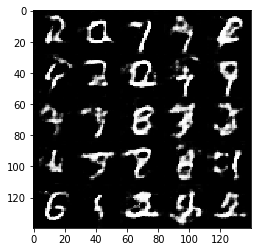

Epoch 1/2	 Batch 410/937	 Discriminator Loss: 1.2725	 Generator Loss: 0.7197
Epoch 1/2	 Batch 420/937	 Discriminator Loss: 1.0659	 Generator Loss: 1.1249
Epoch 1/2	 Batch 430/937	 Discriminator Loss: 1.6105	 Generator Loss: 0.3971
Epoch 1/2	 Batch 440/937	 Discriminator Loss: 1.0652	 Generator Loss: 0.9061
Epoch 1/2	 Batch 450/937	 Discriminator Loss: 1.2101	 Generator Loss: 0.7229
Epoch 1/2	 Batch 460/937	 Discriminator Loss: 1.1683	 Generator Loss: 0.8951
Epoch 1/2	 Batch 470/937	 Discriminator Loss: 1.1219	 Generator Loss: 1.4449
Epoch 1/2	 Batch 480/937	 Discriminator Loss: 1.1708	 Generator Loss: 1.3715
Epoch 1/2	 Batch 490/937	 Discriminator Loss: 1.4503	 Generator Loss: 0.4882
Epoch 1/2	 Batch 500/937	 Discriminator Loss: 1.1416	 Generator Loss: 1.3176
Epoch 1/2	 Batch 510/937	 Discriminator Loss: 1.3772	 Generator Loss: 0.5369
Epoch 1/2	 Batch 520/937	 Discriminator Loss: 1.0811	 Generator Loss: 1.0194
Epoch 1/2	 Batch 530/937	 Discriminator Loss: 1.1374	 Generator Loss: 0.7688

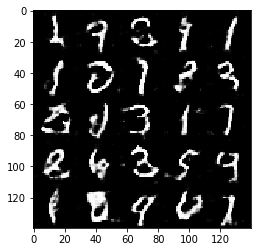

Epoch 1/2	 Batch 610/937	 Discriminator Loss: 1.1360	 Generator Loss: 0.8393
Epoch 1/2	 Batch 620/937	 Discriminator Loss: 1.7966	 Generator Loss: 0.3191
Epoch 1/2	 Batch 630/937	 Discriminator Loss: 0.8623	 Generator Loss: 1.6104
Epoch 1/2	 Batch 640/937	 Discriminator Loss: 0.9445	 Generator Loss: 1.4147
Epoch 1/2	 Batch 650/937	 Discriminator Loss: 1.1882	 Generator Loss: 0.6610
Epoch 1/2	 Batch 660/937	 Discriminator Loss: 1.0622	 Generator Loss: 1.2612
Epoch 1/2	 Batch 670/937	 Discriminator Loss: 1.0265	 Generator Loss: 1.2598
Epoch 1/2	 Batch 680/937	 Discriminator Loss: 1.2482	 Generator Loss: 0.5815
Epoch 1/2	 Batch 690/937	 Discriminator Loss: 1.1828	 Generator Loss: 1.2695
Epoch 1/2	 Batch 700/937	 Discriminator Loss: 0.9049	 Generator Loss: 1.3573
Epoch 1/2	 Batch 710/937	 Discriminator Loss: 0.8514	 Generator Loss: 1.9801
Epoch 1/2	 Batch 720/937	 Discriminator Loss: 1.2740	 Generator Loss: 0.6969
Epoch 1/2	 Batch 730/937	 Discriminator Loss: 1.2435	 Generator Loss: 0.6665

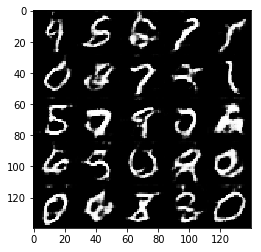

Epoch 1/2	 Batch 810/937	 Discriminator Loss: 1.0808	 Generator Loss: 1.0146
Epoch 1/2	 Batch 820/937	 Discriminator Loss: 1.0738	 Generator Loss: 1.0346
Epoch 1/2	 Batch 830/937	 Discriminator Loss: 1.0814	 Generator Loss: 0.7657
Epoch 1/2	 Batch 840/937	 Discriminator Loss: 1.1199	 Generator Loss: 1.8008
Epoch 1/2	 Batch 850/937	 Discriminator Loss: 1.4298	 Generator Loss: 0.4742
Epoch 1/2	 Batch 860/937	 Discriminator Loss: 0.9318	 Generator Loss: 1.3521
Epoch 1/2	 Batch 870/937	 Discriminator Loss: 1.0101	 Generator Loss: 0.8984
Epoch 1/2	 Batch 880/937	 Discriminator Loss: 0.9568	 Generator Loss: 1.0903
Epoch 1/2	 Batch 890/937	 Discriminator Loss: 1.2828	 Generator Loss: 0.6061
Epoch 1/2	 Batch 900/937	 Discriminator Loss: 1.8713	 Generator Loss: 2.7479
Epoch 1/2	 Batch 910/937	 Discriminator Loss: 1.5696	 Generator Loss: 0.4295
Epoch 1/2	 Batch 920/937	 Discriminator Loss: 1.0704	 Generator Loss: 0.8388
Epoch 1/2	 Batch 930/937	 Discriminator Loss: 1.0267	 Generator Loss: 0.8750

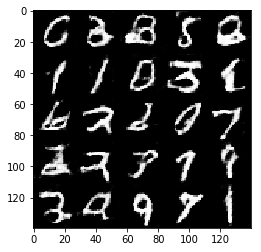

Epoch 2/2	 Batch 10/937	 Discriminator Loss: 1.1233	 Generator Loss: 1.0649
Epoch 2/2	 Batch 20/937	 Discriminator Loss: 1.0952	 Generator Loss: 0.9039
Epoch 2/2	 Batch 30/937	 Discriminator Loss: 1.4558	 Generator Loss: 0.4903
Epoch 2/2	 Batch 40/937	 Discriminator Loss: 1.2056	 Generator Loss: 0.6992
Epoch 2/2	 Batch 50/937	 Discriminator Loss: 1.0681	 Generator Loss: 1.2761
Epoch 2/2	 Batch 60/937	 Discriminator Loss: 0.9393	 Generator Loss: 1.9485
Epoch 2/2	 Batch 70/937	 Discriminator Loss: 1.6798	 Generator Loss: 0.3804
Epoch 2/2	 Batch 80/937	 Discriminator Loss: 1.2200	 Generator Loss: 0.6879
Epoch 2/2	 Batch 90/937	 Discriminator Loss: 1.0405	 Generator Loss: 0.9061
Epoch 2/2	 Batch 100/937	 Discriminator Loss: 0.8634	 Generator Loss: 2.0377
Epoch 2/2	 Batch 110/937	 Discriminator Loss: 0.8641	 Generator Loss: 1.9711
Epoch 2/2	 Batch 120/937	 Discriminator Loss: 1.0291	 Generator Loss: 1.9834
Epoch 2/2	 Batch 130/937	 Discriminator Loss: 1.0169	 Generator Loss: 0.8507
Epoch 2/

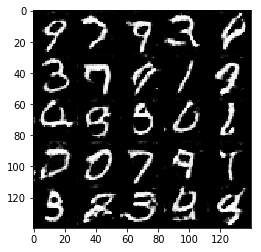

Epoch 2/2	 Batch 210/937	 Discriminator Loss: 0.6904	 Generator Loss: 1.4467
Epoch 2/2	 Batch 220/937	 Discriminator Loss: 0.8326	 Generator Loss: 1.1091
Epoch 2/2	 Batch 230/937	 Discriminator Loss: 1.2382	 Generator Loss: 0.7146
Epoch 2/2	 Batch 240/937	 Discriminator Loss: 0.7911	 Generator Loss: 2.1324
Epoch 2/2	 Batch 250/937	 Discriminator Loss: 0.7050	 Generator Loss: 1.4943
Epoch 2/2	 Batch 260/937	 Discriminator Loss: 0.8352	 Generator Loss: 1.1635
Epoch 2/2	 Batch 270/937	 Discriminator Loss: 3.0194	 Generator Loss: 4.1883
Epoch 2/2	 Batch 280/937	 Discriminator Loss: 1.1439	 Generator Loss: 0.8349
Epoch 2/2	 Batch 290/937	 Discriminator Loss: 0.8840	 Generator Loss: 1.1438
Epoch 2/2	 Batch 300/937	 Discriminator Loss: 1.1510	 Generator Loss: 0.7112
Epoch 2/2	 Batch 310/937	 Discriminator Loss: 1.3547	 Generator Loss: 0.5932
Epoch 2/2	 Batch 320/937	 Discriminator Loss: 1.0211	 Generator Loss: 0.9070
Epoch 2/2	 Batch 330/937	 Discriminator Loss: 0.8812	 Generator Loss: 1.0434

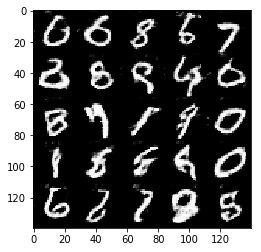

Epoch 2/2	 Batch 410/937	 Discriminator Loss: 0.9461	 Generator Loss: 1.0543
Epoch 2/2	 Batch 420/937	 Discriminator Loss: 0.7470	 Generator Loss: 1.9301
Epoch 2/2	 Batch 430/937	 Discriminator Loss: 0.6836	 Generator Loss: 2.0937
Epoch 2/2	 Batch 440/937	 Discriminator Loss: 0.7767	 Generator Loss: 2.0881
Epoch 2/2	 Batch 450/937	 Discriminator Loss: 1.2554	 Generator Loss: 3.2108
Epoch 2/2	 Batch 460/937	 Discriminator Loss: 0.7194	 Generator Loss: 1.4961
Epoch 2/2	 Batch 470/937	 Discriminator Loss: 0.9398	 Generator Loss: 1.0368
Epoch 2/2	 Batch 480/937	 Discriminator Loss: 0.8420	 Generator Loss: 1.1323
Epoch 2/2	 Batch 490/937	 Discriminator Loss: 0.6267	 Generator Loss: 1.6942
Epoch 2/2	 Batch 500/937	 Discriminator Loss: 1.1511	 Generator Loss: 0.7808
Epoch 2/2	 Batch 510/937	 Discriminator Loss: 1.3405	 Generator Loss: 2.7613
Epoch 2/2	 Batch 520/937	 Discriminator Loss: 0.9056	 Generator Loss: 2.0247
Epoch 2/2	 Batch 530/937	 Discriminator Loss: 0.9450	 Generator Loss: 1.1180

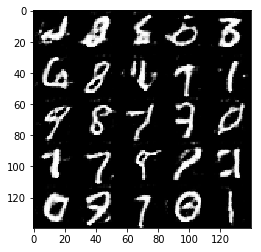

Epoch 2/2	 Batch 610/937	 Discriminator Loss: 0.8242	 Generator Loss: 1.5789
Epoch 2/2	 Batch 620/937	 Discriminator Loss: 1.0457	 Generator Loss: 0.8501
Epoch 2/2	 Batch 630/937	 Discriminator Loss: 0.6987	 Generator Loss: 2.5940
Epoch 2/2	 Batch 640/937	 Discriminator Loss: 0.8555	 Generator Loss: 1.1400
Epoch 2/2	 Batch 650/937	 Discriminator Loss: 2.0819	 Generator Loss: 0.3072
Epoch 2/2	 Batch 660/937	 Discriminator Loss: 0.6069	 Generator Loss: 2.0031
Epoch 2/2	 Batch 670/937	 Discriminator Loss: 0.6157	 Generator Loss: 2.0836
Epoch 2/2	 Batch 680/937	 Discriminator Loss: 1.2787	 Generator Loss: 0.5880
Epoch 2/2	 Batch 690/937	 Discriminator Loss: 0.8507	 Generator Loss: 1.1233
Epoch 2/2	 Batch 700/937	 Discriminator Loss: 0.7104	 Generator Loss: 1.5697
Epoch 2/2	 Batch 710/937	 Discriminator Loss: 0.5904	 Generator Loss: 2.0540
Epoch 2/2	 Batch 720/937	 Discriminator Loss: 0.5612	 Generator Loss: 2.0000
Epoch 2/2	 Batch 730/937	 Discriminator Loss: 1.0483	 Generator Loss: 2.2697

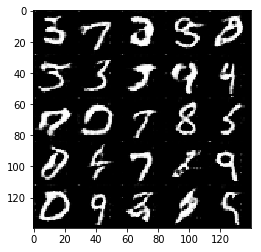

Epoch 2/2	 Batch 810/937	 Discriminator Loss: 0.5184	 Generator Loss: 2.1746
Epoch 2/2	 Batch 820/937	 Discriminator Loss: 1.4752	 Generator Loss: 4.4304
Epoch 2/2	 Batch 830/937	 Discriminator Loss: 0.6812	 Generator Loss: 1.7897
Epoch 2/2	 Batch 840/937	 Discriminator Loss: 0.8091	 Generator Loss: 1.2209
Epoch 2/2	 Batch 850/937	 Discriminator Loss: 0.9014	 Generator Loss: 1.0148
Epoch 2/2	 Batch 860/937	 Discriminator Loss: 0.7059	 Generator Loss: 1.5082
Epoch 2/2	 Batch 870/937	 Discriminator Loss: 0.8745	 Generator Loss: 1.1407
Epoch 2/2	 Batch 880/937	 Discriminator Loss: 0.5819	 Generator Loss: 1.9561
Epoch 2/2	 Batch 890/937	 Discriminator Loss: 0.6596	 Generator Loss: 2.0113
Epoch 2/2	 Batch 900/937	 Discriminator Loss: 0.7010	 Generator Loss: 2.4407
Epoch 2/2	 Batch 910/937	 Discriminator Loss: 1.1337	 Generator Loss: 0.8359
Epoch 2/2	 Batch 920/937	 Discriminator Loss: 0.6224	 Generator Loss: 2.2672
Epoch 2/2	 Batch 930/937	 Discriminator Loss: 1.0177	 Generator Loss: 1.0193

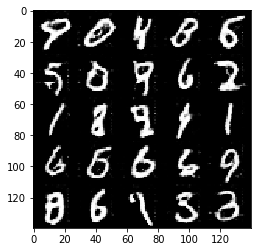

In [12]:
batch_size = 64
z_dim = 128
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Change value range of dataset from [-0.5, 0.5] to [-1, 1]
Epoch 1/1	 Batch 10/3165	 Discriminator Loss: 1.0716	 Generator Loss: 16.3609
Epoch 1/1	 Batch 20/3165	 Discriminator Loss: 0.5196	 Generator Loss: 14.7773
Epoch 1/1	 Batch 30/3165	 Discriminator Loss: 0.4572	 Generator Loss: 10.3085
Epoch 1/1	 Batch 40/3165	 Discriminator Loss: 2.8243	 Generator Loss: 0.1384
Epoch 1/1	 Batch 50/3165	 Discriminator Loss: 0.5898	 Generator Loss: 10.9239
Epoch 1/1	 Batch 60/3165	 Discriminator Loss: 1.3216	 Generator Loss: 6.5699
Epoch 1/1	 Batch 70/3165	 Discriminator Loss: 1.2393	 Generator Loss: 1.0172
Epoch 1/1	 Batch 80/3165	 Discriminator Loss: 0.7014	 Generator Loss: 1.6779
Epoch 1/1	 Batch 90/3165	 Discriminator Loss: 1.0075	 Generator Loss: 1.0129
Epoch 1/1	 Batch 100/3165	 Discriminator Loss: 0.8492	 Generator Loss: 1.3343
Epoch 1/1	 Batch 110/3165	 Discriminator Loss: 1.4427	 Generator Loss: 0.6193
Epoch 1/1	 Batch 120/3165	 Discriminator Loss: 1.1894	 Generator Loss: 4.3382
Epoch 1/1	 

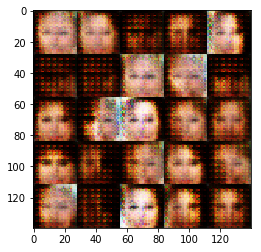

Epoch 1/1	 Batch 210/3165	 Discriminator Loss: 1.1630	 Generator Loss: 1.5332
Epoch 1/1	 Batch 220/3165	 Discriminator Loss: 1.3067	 Generator Loss: 0.8389
Epoch 1/1	 Batch 230/3165	 Discriminator Loss: 1.2401	 Generator Loss: 0.7492
Epoch 1/1	 Batch 240/3165	 Discriminator Loss: 0.8164	 Generator Loss: 1.8213
Epoch 1/1	 Batch 250/3165	 Discriminator Loss: 1.7077	 Generator Loss: 0.4697
Epoch 1/1	 Batch 260/3165	 Discriminator Loss: 1.0039	 Generator Loss: 1.5700
Epoch 1/1	 Batch 270/3165	 Discriminator Loss: 1.1720	 Generator Loss: 0.9152
Epoch 1/1	 Batch 280/3165	 Discriminator Loss: 1.0516	 Generator Loss: 1.8095
Epoch 1/1	 Batch 290/3165	 Discriminator Loss: 1.2286	 Generator Loss: 1.5375
Epoch 1/1	 Batch 300/3165	 Discriminator Loss: 2.4516	 Generator Loss: 0.2138
Epoch 1/1	 Batch 310/3165	 Discriminator Loss: 1.1589	 Generator Loss: 1.1277
Epoch 1/1	 Batch 320/3165	 Discriminator Loss: 0.9854	 Generator Loss: 1.3361
Epoch 1/1	 Batch 330/3165	 Discriminator Loss: 0.9175	 Generator

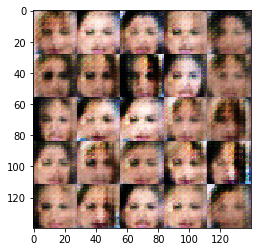

Epoch 1/1	 Batch 410/3165	 Discriminator Loss: 0.9254	 Generator Loss: 2.6002
Epoch 1/1	 Batch 420/3165	 Discriminator Loss: 1.1244	 Generator Loss: 1.9607
Epoch 1/1	 Batch 430/3165	 Discriminator Loss: 1.6977	 Generator Loss: 4.0228
Epoch 1/1	 Batch 440/3165	 Discriminator Loss: 0.9378	 Generator Loss: 1.6661
Epoch 1/1	 Batch 450/3165	 Discriminator Loss: 1.1951	 Generator Loss: 0.7624
Epoch 1/1	 Batch 460/3165	 Discriminator Loss: 1.4893	 Generator Loss: 0.4624
Epoch 1/1	 Batch 470/3165	 Discriminator Loss: 1.0130	 Generator Loss: 1.2534
Epoch 1/1	 Batch 480/3165	 Discriminator Loss: 0.9015	 Generator Loss: 1.4899
Epoch 1/1	 Batch 490/3165	 Discriminator Loss: 0.8827	 Generator Loss: 1.4257
Epoch 1/1	 Batch 500/3165	 Discriminator Loss: 0.9650	 Generator Loss: 1.1680
Epoch 1/1	 Batch 510/3165	 Discriminator Loss: 1.0518	 Generator Loss: 1.1777
Epoch 1/1	 Batch 520/3165	 Discriminator Loss: 1.1343	 Generator Loss: 1.9782
Epoch 1/1	 Batch 530/3165	 Discriminator Loss: 0.9573	 Generator

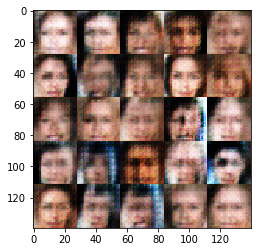

Epoch 1/1	 Batch 610/3165	 Discriminator Loss: 1.0026	 Generator Loss: 0.9505
Epoch 1/1	 Batch 620/3165	 Discriminator Loss: 1.1893	 Generator Loss: 0.9386
Epoch 1/1	 Batch 630/3165	 Discriminator Loss: 1.1201	 Generator Loss: 1.2331
Epoch 1/1	 Batch 640/3165	 Discriminator Loss: 1.2089	 Generator Loss: 1.2193
Epoch 1/1	 Batch 650/3165	 Discriminator Loss: 1.0845	 Generator Loss: 0.9531
Epoch 1/1	 Batch 660/3165	 Discriminator Loss: 1.4002	 Generator Loss: 1.9019
Epoch 1/1	 Batch 670/3165	 Discriminator Loss: 1.1741	 Generator Loss: 1.1441
Epoch 1/1	 Batch 680/3165	 Discriminator Loss: 1.2449	 Generator Loss: 0.8056
Epoch 1/1	 Batch 690/3165	 Discriminator Loss: 1.4451	 Generator Loss: 0.5314
Epoch 1/1	 Batch 700/3165	 Discriminator Loss: 1.2257	 Generator Loss: 1.7029
Epoch 1/1	 Batch 710/3165	 Discriminator Loss: 1.0940	 Generator Loss: 1.4883
Epoch 1/1	 Batch 720/3165	 Discriminator Loss: 1.4362	 Generator Loss: 1.8308
Epoch 1/1	 Batch 730/3165	 Discriminator Loss: 0.9963	 Generator

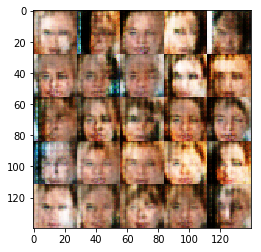

Epoch 1/1	 Batch 810/3165	 Discriminator Loss: 1.2078	 Generator Loss: 1.2935
Epoch 1/1	 Batch 820/3165	 Discriminator Loss: 1.2105	 Generator Loss: 1.2592
Epoch 1/1	 Batch 830/3165	 Discriminator Loss: 1.1393	 Generator Loss: 0.7719
Epoch 1/1	 Batch 840/3165	 Discriminator Loss: 1.0784	 Generator Loss: 1.1274
Epoch 1/1	 Batch 850/3165	 Discriminator Loss: 1.1209	 Generator Loss: 0.8884
Epoch 1/1	 Batch 860/3165	 Discriminator Loss: 1.1634	 Generator Loss: 2.4995
Epoch 1/1	 Batch 870/3165	 Discriminator Loss: 1.2543	 Generator Loss: 1.4256
Epoch 1/1	 Batch 880/3165	 Discriminator Loss: 1.0648	 Generator Loss: 1.0579
Epoch 1/1	 Batch 890/3165	 Discriminator Loss: 1.2432	 Generator Loss: 0.7798
Epoch 1/1	 Batch 900/3165	 Discriminator Loss: 1.0205	 Generator Loss: 1.3858
Epoch 1/1	 Batch 910/3165	 Discriminator Loss: 1.1511	 Generator Loss: 1.5024
Epoch 1/1	 Batch 920/3165	 Discriminator Loss: 1.1196	 Generator Loss: 0.8184
Epoch 1/1	 Batch 930/3165	 Discriminator Loss: 1.0324	 Generator

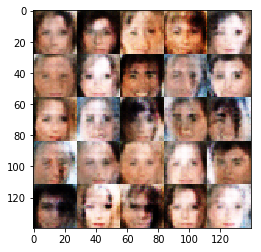

Epoch 1/1	 Batch 1010/3165	 Discriminator Loss: 1.2030	 Generator Loss: 0.7470
Epoch 1/1	 Batch 1020/3165	 Discriminator Loss: 0.9435	 Generator Loss: 1.2360
Epoch 1/1	 Batch 1030/3165	 Discriminator Loss: 1.5007	 Generator Loss: 0.4595
Epoch 1/1	 Batch 1040/3165	 Discriminator Loss: 1.1955	 Generator Loss: 2.1220
Epoch 1/1	 Batch 1050/3165	 Discriminator Loss: 1.1013	 Generator Loss: 1.5495
Epoch 1/1	 Batch 1060/3165	 Discriminator Loss: 1.0682	 Generator Loss: 0.8845
Epoch 1/1	 Batch 1070/3165	 Discriminator Loss: 1.1436	 Generator Loss: 0.7249
Epoch 1/1	 Batch 1080/3165	 Discriminator Loss: 1.1716	 Generator Loss: 1.0344
Epoch 1/1	 Batch 1090/3165	 Discriminator Loss: 1.1971	 Generator Loss: 1.2162
Epoch 1/1	 Batch 1100/3165	 Discriminator Loss: 0.9859	 Generator Loss: 1.1269
Epoch 1/1	 Batch 1110/3165	 Discriminator Loss: 1.1726	 Generator Loss: 0.8490
Epoch 1/1	 Batch 1120/3165	 Discriminator Loss: 1.3225	 Generator Loss: 0.6146
Epoch 1/1	 Batch 1130/3165	 Discriminator Loss: 1.22

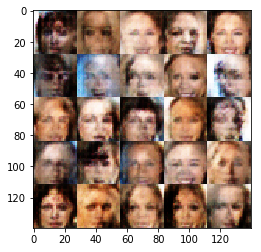

Epoch 1/1	 Batch 1210/3165	 Discriminator Loss: 1.5144	 Generator Loss: 0.5009
Epoch 1/1	 Batch 1220/3165	 Discriminator Loss: 1.1430	 Generator Loss: 2.2083
Epoch 1/1	 Batch 1230/3165	 Discriminator Loss: 1.0910	 Generator Loss: 1.3380
Epoch 1/1	 Batch 1240/3165	 Discriminator Loss: 1.0189	 Generator Loss: 0.9645
Epoch 1/1	 Batch 1250/3165	 Discriminator Loss: 1.1059	 Generator Loss: 0.8625
Epoch 1/1	 Batch 1260/3165	 Discriminator Loss: 1.4510	 Generator Loss: 0.5215
Epoch 1/1	 Batch 1270/3165	 Discriminator Loss: 1.0226	 Generator Loss: 1.0035
Epoch 1/1	 Batch 1280/3165	 Discriminator Loss: 1.4187	 Generator Loss: 0.5312
Epoch 1/1	 Batch 1290/3165	 Discriminator Loss: 1.4948	 Generator Loss: 0.4603
Epoch 1/1	 Batch 1300/3165	 Discriminator Loss: 0.9498	 Generator Loss: 1.2187
Epoch 1/1	 Batch 1310/3165	 Discriminator Loss: 1.2001	 Generator Loss: 0.8344
Epoch 1/1	 Batch 1320/3165	 Discriminator Loss: 1.1516	 Generator Loss: 1.0026
Epoch 1/1	 Batch 1330/3165	 Discriminator Loss: 1.27

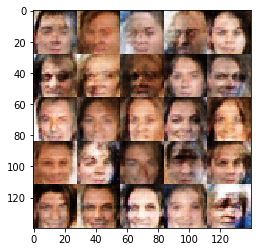

Epoch 1/1	 Batch 1410/3165	 Discriminator Loss: 1.3665	 Generator Loss: 0.5647
Epoch 1/1	 Batch 1420/3165	 Discriminator Loss: 1.0115	 Generator Loss: 1.1349
Epoch 1/1	 Batch 1430/3165	 Discriminator Loss: 1.1991	 Generator Loss: 0.9587
Epoch 1/1	 Batch 1440/3165	 Discriminator Loss: 0.9970	 Generator Loss: 1.0365
Epoch 1/1	 Batch 1450/3165	 Discriminator Loss: 1.3334	 Generator Loss: 0.6242
Epoch 1/1	 Batch 1460/3165	 Discriminator Loss: 1.0596	 Generator Loss: 1.1395
Epoch 1/1	 Batch 1470/3165	 Discriminator Loss: 1.1308	 Generator Loss: 0.8190
Epoch 1/1	 Batch 1480/3165	 Discriminator Loss: 1.2858	 Generator Loss: 0.6090
Epoch 1/1	 Batch 1490/3165	 Discriminator Loss: 1.1727	 Generator Loss: 1.0968
Epoch 1/1	 Batch 1500/3165	 Discriminator Loss: 1.1591	 Generator Loss: 1.2364
Epoch 1/1	 Batch 1510/3165	 Discriminator Loss: 1.2299	 Generator Loss: 0.7654
Epoch 1/1	 Batch 1520/3165	 Discriminator Loss: 1.3370	 Generator Loss: 0.5838
Epoch 1/1	 Batch 1530/3165	 Discriminator Loss: 1.17

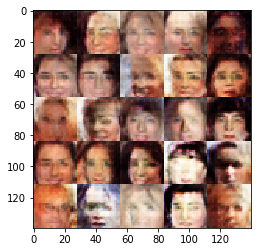

Epoch 1/1	 Batch 1610/3165	 Discriminator Loss: 1.0850	 Generator Loss: 1.3496
Epoch 1/1	 Batch 1620/3165	 Discriminator Loss: 1.3504	 Generator Loss: 0.5695
Epoch 1/1	 Batch 1630/3165	 Discriminator Loss: 1.1663	 Generator Loss: 1.3522
Epoch 1/1	 Batch 1640/3165	 Discriminator Loss: 1.3346	 Generator Loss: 1.9488
Epoch 1/1	 Batch 1650/3165	 Discriminator Loss: 1.6889	 Generator Loss: 0.3550
Epoch 1/1	 Batch 1660/3165	 Discriminator Loss: 1.1481	 Generator Loss: 0.9430
Epoch 1/1	 Batch 1670/3165	 Discriminator Loss: 1.2817	 Generator Loss: 0.6570
Epoch 1/1	 Batch 1680/3165	 Discriminator Loss: 1.4485	 Generator Loss: 1.5960
Epoch 1/1	 Batch 1690/3165	 Discriminator Loss: 1.0296	 Generator Loss: 1.2216
Epoch 1/1	 Batch 1700/3165	 Discriminator Loss: 1.1835	 Generator Loss: 0.7760
Epoch 1/1	 Batch 1710/3165	 Discriminator Loss: 1.1534	 Generator Loss: 1.0616
Epoch 1/1	 Batch 1720/3165	 Discriminator Loss: 1.2502	 Generator Loss: 1.0336
Epoch 1/1	 Batch 1730/3165	 Discriminator Loss: 1.20

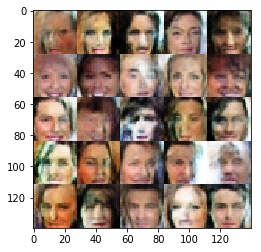

Epoch 1/1	 Batch 1810/3165	 Discriminator Loss: 1.2801	 Generator Loss: 0.7852
Epoch 1/1	 Batch 1820/3165	 Discriminator Loss: 1.1001	 Generator Loss: 0.8502
Epoch 1/1	 Batch 1830/3165	 Discriminator Loss: 1.3316	 Generator Loss: 0.9072
Epoch 1/1	 Batch 1840/3165	 Discriminator Loss: 1.4159	 Generator Loss: 0.9515
Epoch 1/1	 Batch 1850/3165	 Discriminator Loss: 1.5044	 Generator Loss: 0.4327
Epoch 1/1	 Batch 1860/3165	 Discriminator Loss: 1.0689	 Generator Loss: 0.8850
Epoch 1/1	 Batch 1870/3165	 Discriminator Loss: 1.1395	 Generator Loss: 0.8142
Epoch 1/1	 Batch 1880/3165	 Discriminator Loss: 0.9228	 Generator Loss: 1.3423
Epoch 1/1	 Batch 1890/3165	 Discriminator Loss: 1.4700	 Generator Loss: 0.5703
Epoch 1/1	 Batch 1900/3165	 Discriminator Loss: 1.1523	 Generator Loss: 1.3533
Epoch 1/1	 Batch 1910/3165	 Discriminator Loss: 1.2161	 Generator Loss: 0.7404
Epoch 1/1	 Batch 1920/3165	 Discriminator Loss: 1.3896	 Generator Loss: 0.5888
Epoch 1/1	 Batch 1930/3165	 Discriminator Loss: 1.14

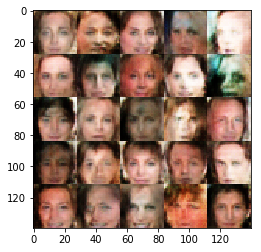

Epoch 1/1	 Batch 2010/3165	 Discriminator Loss: 1.1149	 Generator Loss: 0.9727
Epoch 1/1	 Batch 2020/3165	 Discriminator Loss: 1.0246	 Generator Loss: 0.9871
Epoch 1/1	 Batch 2030/3165	 Discriminator Loss: 1.3878	 Generator Loss: 0.6040
Epoch 1/1	 Batch 2040/3165	 Discriminator Loss: 1.0570	 Generator Loss: 0.9851
Epoch 1/1	 Batch 2050/3165	 Discriminator Loss: 1.5228	 Generator Loss: 0.4474
Epoch 1/1	 Batch 2060/3165	 Discriminator Loss: 1.3496	 Generator Loss: 0.7428
Epoch 1/1	 Batch 2070/3165	 Discriminator Loss: 1.0213	 Generator Loss: 1.0148
Epoch 1/1	 Batch 2080/3165	 Discriminator Loss: 1.2750	 Generator Loss: 1.3570
Epoch 1/1	 Batch 2090/3165	 Discriminator Loss: 1.2742	 Generator Loss: 0.6774
Epoch 1/1	 Batch 2100/3165	 Discriminator Loss: 0.9026	 Generator Loss: 1.3406
Epoch 1/1	 Batch 2110/3165	 Discriminator Loss: 1.0330	 Generator Loss: 1.4206
Epoch 1/1	 Batch 2120/3165	 Discriminator Loss: 1.3462	 Generator Loss: 0.5745
Epoch 1/1	 Batch 2130/3165	 Discriminator Loss: 0.88

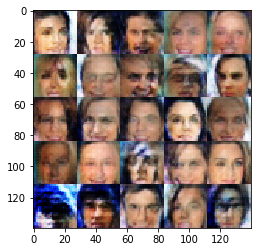

Epoch 1/1	 Batch 2210/3165	 Discriminator Loss: 1.7209	 Generator Loss: 0.4103
Epoch 1/1	 Batch 2220/3165	 Discriminator Loss: 0.9956	 Generator Loss: 1.2165
Epoch 1/1	 Batch 2230/3165	 Discriminator Loss: 1.3620	 Generator Loss: 0.9198
Epoch 1/1	 Batch 2240/3165	 Discriminator Loss: 1.3853	 Generator Loss: 1.1790
Epoch 1/1	 Batch 2250/3165	 Discriminator Loss: 1.3799	 Generator Loss: 0.7617
Epoch 1/1	 Batch 2260/3165	 Discriminator Loss: 1.2594	 Generator Loss: 1.0034
Epoch 1/1	 Batch 2270/3165	 Discriminator Loss: 1.3254	 Generator Loss: 0.6045
Epoch 1/1	 Batch 2280/3165	 Discriminator Loss: 1.2646	 Generator Loss: 1.0966
Epoch 1/1	 Batch 2290/3165	 Discriminator Loss: 1.2068	 Generator Loss: 0.9962
Epoch 1/1	 Batch 2300/3165	 Discriminator Loss: 1.3821	 Generator Loss: 0.5819
Epoch 1/1	 Batch 2310/3165	 Discriminator Loss: 1.1157	 Generator Loss: 1.4885
Epoch 1/1	 Batch 2320/3165	 Discriminator Loss: 1.4546	 Generator Loss: 0.4803
Epoch 1/1	 Batch 2330/3165	 Discriminator Loss: 1.21

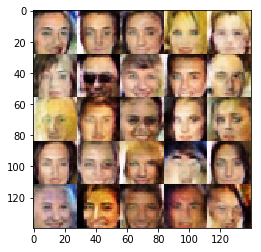

Epoch 1/1	 Batch 2410/3165	 Discriminator Loss: 1.3251	 Generator Loss: 0.5828
Epoch 1/1	 Batch 2420/3165	 Discriminator Loss: 0.9291	 Generator Loss: 1.1470
Epoch 1/1	 Batch 2430/3165	 Discriminator Loss: 1.2203	 Generator Loss: 0.7256
Epoch 1/1	 Batch 2440/3165	 Discriminator Loss: 1.2041	 Generator Loss: 0.9756
Epoch 1/1	 Batch 2450/3165	 Discriminator Loss: 1.3114	 Generator Loss: 0.6975
Epoch 1/1	 Batch 2460/3165	 Discriminator Loss: 1.1993	 Generator Loss: 0.8962
Epoch 1/1	 Batch 2470/3165	 Discriminator Loss: 1.2580	 Generator Loss: 0.8701
Epoch 1/1	 Batch 2480/3165	 Discriminator Loss: 1.2719	 Generator Loss: 0.6585
Epoch 1/1	 Batch 2490/3165	 Discriminator Loss: 1.2691	 Generator Loss: 0.7303
Epoch 1/1	 Batch 2500/3165	 Discriminator Loss: 1.2219	 Generator Loss: 0.9355
Epoch 1/1	 Batch 2510/3165	 Discriminator Loss: 1.2603	 Generator Loss: 0.6384
Epoch 1/1	 Batch 2520/3165	 Discriminator Loss: 1.2398	 Generator Loss: 0.6965
Epoch 1/1	 Batch 2530/3165	 Discriminator Loss: 1.40

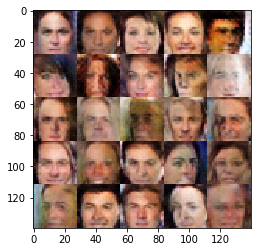

Epoch 1/1	 Batch 2610/3165	 Discriminator Loss: 1.2626	 Generator Loss: 1.1936
Epoch 1/1	 Batch 2620/3165	 Discriminator Loss: 1.2709	 Generator Loss: 0.7529
Epoch 1/1	 Batch 2630/3165	 Discriminator Loss: 1.2927	 Generator Loss: 1.1549
Epoch 1/1	 Batch 2640/3165	 Discriminator Loss: 1.3964	 Generator Loss: 1.3971
Epoch 1/1	 Batch 2650/3165	 Discriminator Loss: 1.5515	 Generator Loss: 0.4515
Epoch 1/1	 Batch 2660/3165	 Discriminator Loss: 1.2554	 Generator Loss: 0.8656
Epoch 1/1	 Batch 2670/3165	 Discriminator Loss: 1.3217	 Generator Loss: 0.8589
Epoch 1/1	 Batch 2680/3165	 Discriminator Loss: 1.2532	 Generator Loss: 1.0343
Epoch 1/1	 Batch 2690/3165	 Discriminator Loss: 1.1955	 Generator Loss: 0.7682
Epoch 1/1	 Batch 2700/3165	 Discriminator Loss: 1.3785	 Generator Loss: 0.6588
Epoch 1/1	 Batch 2710/3165	 Discriminator Loss: 1.3994	 Generator Loss: 0.5753
Epoch 1/1	 Batch 2720/3165	 Discriminator Loss: 1.0334	 Generator Loss: 1.4220
Epoch 1/1	 Batch 2730/3165	 Discriminator Loss: 1.25

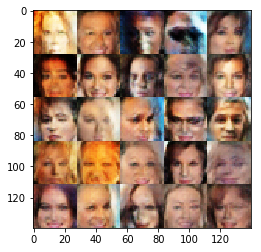

Epoch 1/1	 Batch 2810/3165	 Discriminator Loss: 1.2901	 Generator Loss: 0.8219
Epoch 1/1	 Batch 2820/3165	 Discriminator Loss: 1.1537	 Generator Loss: 0.8549
Epoch 1/1	 Batch 2830/3165	 Discriminator Loss: 1.3588	 Generator Loss: 1.4978
Epoch 1/1	 Batch 2840/3165	 Discriminator Loss: 0.9660	 Generator Loss: 1.2282
Epoch 1/1	 Batch 2850/3165	 Discriminator Loss: 1.2238	 Generator Loss: 1.0118
Epoch 1/1	 Batch 2860/3165	 Discriminator Loss: 1.3448	 Generator Loss: 0.7017
Epoch 1/1	 Batch 2870/3165	 Discriminator Loss: 1.3569	 Generator Loss: 1.4576
Epoch 1/1	 Batch 2880/3165	 Discriminator Loss: 1.1185	 Generator Loss: 1.1420
Epoch 1/1	 Batch 2890/3165	 Discriminator Loss: 1.3259	 Generator Loss: 0.8364
Epoch 1/1	 Batch 2900/3165	 Discriminator Loss: 1.3511	 Generator Loss: 0.6159
Epoch 1/1	 Batch 2910/3165	 Discriminator Loss: 1.4991	 Generator Loss: 0.4269
Epoch 1/1	 Batch 2920/3165	 Discriminator Loss: 1.3447	 Generator Loss: 0.6360
Epoch 1/1	 Batch 2930/3165	 Discriminator Loss: 1.22

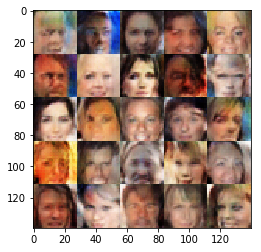

Epoch 1/1	 Batch 3010/3165	 Discriminator Loss: 1.1761	 Generator Loss: 0.7854
Epoch 1/1	 Batch 3020/3165	 Discriminator Loss: 1.2132	 Generator Loss: 0.7999
Epoch 1/1	 Batch 3030/3165	 Discriminator Loss: 1.3988	 Generator Loss: 0.5495
Epoch 1/1	 Batch 3040/3165	 Discriminator Loss: 1.1855	 Generator Loss: 1.5699
Epoch 1/1	 Batch 3050/3165	 Discriminator Loss: 1.2620	 Generator Loss: 0.9796
Epoch 1/1	 Batch 3060/3165	 Discriminator Loss: 1.3090	 Generator Loss: 0.6217
Epoch 1/1	 Batch 3070/3165	 Discriminator Loss: 1.1806	 Generator Loss: 0.9985
Epoch 1/1	 Batch 3080/3165	 Discriminator Loss: 1.4578	 Generator Loss: 1.1576
Epoch 1/1	 Batch 3090/3165	 Discriminator Loss: 1.4347	 Generator Loss: 0.5279
Epoch 1/1	 Batch 3100/3165	 Discriminator Loss: 1.3235	 Generator Loss: 0.6265
Epoch 1/1	 Batch 3110/3165	 Discriminator Loss: 0.9954	 Generator Loss: 1.2642
Epoch 1/1	 Batch 3120/3165	 Discriminator Loss: 1.4008	 Generator Loss: 0.5681
Epoch 1/1	 Batch 3130/3165	 Discriminator Loss: 1.33

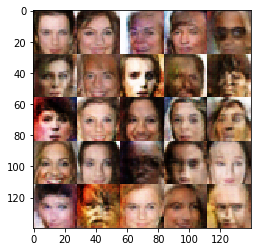

In [13]:
batch_size = 64
z_dim = 128
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.